In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!pip install -q git+https://github.com/tensorflow/docs


import urllib

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import numpy as np


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#Load training data

In [ ]:

import random
from keras.preprocessing.image import load_img     # Loading images in PIL
from os import listdir  # Gives directories of all files in the form of a list for easy access
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras import regularizers
from keras.utils import to_categorical
from keras import regularizers
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import SGD

#The code below loads all the necessary folders

!cp '/content/gdrive/My Drive/AugmentedData3.zip' TrainingDataNew3.zip
!unzip TrainingDataNew3.zip

!cp '/content/gdrive/My Drive/AugmentedData4.zip' TrainingDataNew4.zip
!unzip TrainingDataNew4.zip

!cp '/content/gdrive/My Drive/AugmentedData5.zip' TrainingDataNew5.zip
!unzip TrainingDataNew5.zip

#!cp '/content/gdrive/My Drive/TrainData3.zip' TrainingData3.zip
#!unzip TrainingData3.zip

#!cp '/content/gdrive/My Drive/ValData.zip' ValidationData.zip
#!unzip ValidationData.zip

Using TensorFlow backend.


Streaming output truncated to the last 5000 lines.
  inflating: AugmentedData5/DownMobile/3130.jpg  
  inflating: AugmentedData5/Alert/1133.jpg  
  inflating: AugmentedData5/Alert/1583.jpg  
  inflating: AugmentedData5/Alert/1073.jpg  
  inflating: AugmentedData5/DownMobile/1062.jpg  
  inflating: AugmentedData5/DownMobile/1004.jpg  
  inflating: AugmentedData5/UpMobile/1678.jpg  
  inflating: AugmentedData5/Alert/1065.jpg  
  inflating: AugmentedData5/Alert/1174.jpg  
  inflating: AugmentedData5/Alert/1140.jpg  
  inflating: AugmentedData5/Alert/1075.jpg  
  inflating: AugmentedData5/Alert/2908.jpg  
  inflating: AugmentedData5/Alert/1087.jpg  
  inflating: AugmentedData5/Alert/1151.jpg  
  inflating: AugmentedData5/DownMobile/846.jpg  
  inflating: AugmentedData5/DownMobile/1023.jpg  
  inflating: AugmentedData5/Distracted/1337.jpg  
  inflating: AugmentedData5/Alert/1168.jpg  
  inflating: AugmentedData5/DownMobile/938.jpg  
  inflating: AugmentedData5/DownMobile/845.jpg  
  inflati

In [ ]:
#The parameters define the size an image is compressed to
height = 96
width = 32

#Index of categories defined
categories = {'Alert': 0, 'Distracted': 1, 'UpMobile': 2, 'DownMobile': 3}

#Augmentation dictionary refers to how many augmented images for each category exist for an original image
#Augmentation = {'Alert':2 , 'Distracted':4, 'UpMobile': 5, 'DownMobile': 4} # Aug3
Augmentation = {'Alert':4 , 'Distracted':6, 'UpMobile': 8, 'DownMobile': 6} # Aug4
#Augmentation = {'Alert':8 , 'Distracted':12, 'UpMobile': 16, 'DownMobile': 12} # Aug5


#The set of codes below load the input data into training and validation data with a given split. 85/15 in this case.
def shuffle_two(a, b):
  x, y = a, b
  c = list(zip(x, y))
  random.shuffle(c)
  x, y = zip(*c)
  return x, y

def shuffle_three(a, b, c):
  x, y, z = a, b, c
  c = list(zip(x, y, z))
  random.shuffle(c)
  x, y, z = zip(*c)
  return x, y, z

def loadImages(directory, split=0.40):
  TrainImages = []
  Trainlabels = []
  ValidationImages = []
  Validationlabels = []
  Validationfilenames = []

  # Getting Validation Data
  for folder in listdir(directory):
    numImages = len(listdir(directory+'/'+folder))
    print(folder + ':',  numImages)
    UI = []
    UL = []
    UF = []

    # Extract Unique or Unaugmented Images of the current category
    for i in range(0, numImages, Augmentation[folder]):
        filename =  directory + '/' + folder + '/' + str(i) + '.jpg'
        #print(filename)
        try: image = load_img(filename, target_size=(height, width))
        except: continue
        try: image = img_to_array(image)
        except: continue
        UI.append(image)
        UL.append(categories[folder])
        UF.append(i)

    extractImages = len(UI)*split

    # Shuffle these unique images and add a percentage of them to the validation splot
    uniqueImages, uniqueLabels, uniqueFilenames = shuffle_three(UI, UL, UF)
    ValidationImages += uniqueImages[:int(extractImages)]
    Validationlabels += uniqueLabels[:int(extractImages)]
    UF = uniqueFilenames[:int(extractImages)]
    print('Getting',  int(extractImages), 'out of', len(UI),'unique images for validation')
    print(' ')

    # Also, add the next X augmented filenames/images in the list too, so they don't get added to the training set
    for filename in UF:
      Validationfilenames.append(directory +'/' + folder +'/' + str(filename) + '.jpg')
      index = int(filename)
      count = 1
      for i in range(Augmentation[folder]-1):
        Validationfilenames.append(directory +'/' + folder +'/' + str(index+count) + '.jpg')
        count += 1

  print("--------------------------------------------")
  # Getting Training Data
  for folder in listdir(directory):
    count = 0
    for image in listdir(directory+'/'+folder):
      filename =  directory + '/' + folder + '/' + image
      if filename not in Validationfilenames:                       # Check if it isn't one of the files corresponding to validation images
          try: image = load_img(filename, target_size=(height, width))
          except: continue
          try: image = img_to_array(image)
          except: continue
          TrainImages.append(image)
          Trainlabels.append(categories[folder])
          count += 1
          if categories[folder] == 0 and count == 90000: break
    print('Training Data Extracted From ' + folder, count)

  return TrainImages, Trainlabels, ValidationImages, Validationlabels
  
#Unshuffled images and labels 
a, b, c, d = loadImages('AugmentedData4', 0.15) ##CHANGE AUG DICTIONARY
a = [im.astype(int) for im in a]
c = [im.astype(int) for im in c]


#Shuffled Training Images and Labels
TrainImages, Trainlabels = shuffle_two(a, b)
TrainImages, Trainlabels = np.array(TrainImages), np.array(Trainlabels)

#Shuffled Validation Images and Labels
ValidationImages, Validationlabels = shuffle_two(c, d)
ValidationImages, Validationlabels = np.array(ValidationImages), np.array(Validationlabels)

# Total Count
TimageCount = len(TrainImages)
TlabelCount = len(Trainlabels)
VimageCount = len(ValidationImages)
VlabelCount = len(Validationlabels)
print(' ')
print('Total Number of Train Images & Labels | Val Images & Labels: ', TimageCount, TlabelCount, ' | ',VimageCount, VlabelCount)

#(x_train, y_train), (x_val, y_val) = (TrainImages, Trainlabels), (ValidationImages, Validationlabels)


Distracted: 1539
Getting 37 out of 247 unique images for validation
 
DownMobile: 1644
Getting 40 out of 273 unique images for validation
 
UpMobile: 1464
Getting 27 out of 182 unique images for validation
 
Alert: 1688
Getting 63 out of 421 unique images for validation
 
--------------------------------------------
Training Data Extracted From Distracted 1317
Training Data Extracted From DownMobile 1404
Training Data Extracted From UpMobile 1248
Training Data Extracted From Alert 1436
 
Total Number of Train Images & Labels | Val Images & Labels:  5405 5405  |  167 167


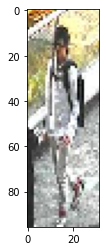

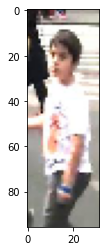

<Figure size 432x288 with 0 Axes>

In [ ]:
#Prints images to see how they appear for the image size and confirm that they are shuffled

(x_train, y_train), (x_test, y_test) = (TrainImages, Trainlabels), (ValidationImages, Validationlabels)

for i in range(50,52):
  plt.imshow(x_test[i], cmap = 'BrBG')
  plt.figure()

#Train VGG16 model

(5405, 4)
58892288/58889256 [==============================] - 3s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 16, 128)       147584    
__________________________________________________

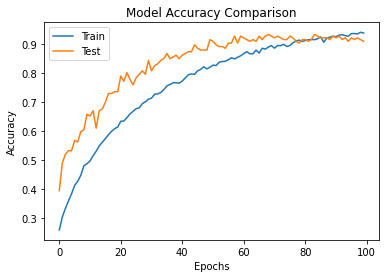

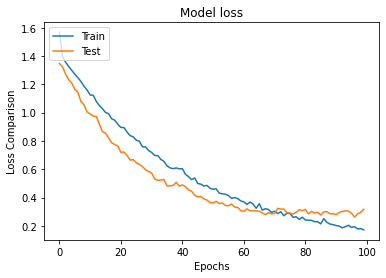

In [ ]:
#x_train is training data and x_test is the validationdata
(x_train, y_train), (x_test, y_test) = (TrainImages, Trainlabels), (ValidationImages, Validationlabels)

#Libraries might have been imported twice.
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
import cv2
import numpy as np
import matplotlib.pyplot as plt


#Let's preprocess as per VGG16 requirement
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train.shape)


#Define a model for VGG16, not including the final layers. i.e. model cut off just before the flatten layer. Used for feature extraction only.
model = VGG16(include_top=False, input_shape=(height, width, 3))
#print(model.summary())

#Train only the layers after the VGG16 feature extraction layers. 
for layer in model.layers:
    layer.trainable=False

#Add new layers to be part of our classifier, architecture not fixed but changed around to optimize
f1 = Flatten()(model.layers[-1].output)
n = BatchNormalization()(f1)
dr1 = Dropout(0.45)(n)
c1 = Dense(2048,  activation='relu')(dr1)
dr2 = Dropout(0.45)(c1)
c2 = Dense(1024, activation='relu')(dr2)
dr3 = Dropout(0.45)(c2)
c3 = Dense(512, activation='relu')(dr3)
dr4 = Dropout(0.45)(c3)        
c4 = Dense(256, activation='relu')(dr4)    # possibility, c4 = Dense(512, activation = 'relu', activity_regularizer=regularizers.l1(1e-6))(fl)
dr5 = Dropout(0.45)(c4)
output = Dense(4, activation='softmax')(dr5)

#Define new model combining the partial VGG16 model with our layers attached at the end
model_1 = Model(inputs=model.inputs, outputs=output)

#Note how model_1 corresponds to VGG16 model
model_1.summary()
#print(model_1.summary())

#Train model

#Vary paramaters of SGD more minutely
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model_1.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['acc']) 
record = model_1.fit(x_train, y_train, epochs = 100, batch_size = 16, validation_data=(x_test, y_test))


# Plot training & validation accuracy values
plt.plot(record.history['acc'])
plt.plot(record.history['val_acc'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.figure()
# Plot training & validation loss values
plt.plot(record.history['loss'])
plt.plot(record.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss Comparison')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Some rough notes about different outputs for different configurations are made below. The conclusion was cleaned up and added to the report. 

#Validation data has augmented and shuffleddata
# with sgd, categorical, and only dense + dropout 16 batch and 32x64 got pretty great graphs but only 34% test acc
# 62,128 with sgd 0.01 dropout 0.3 16 batch 42%
#32, 96 with adagrad and dropout 0.4 100 epochs gives great graphs but 40%


#With AugmentedData3
#32,96 with Adam gives like 88% and test acc. 58% which is v. nice
#32,96 with Adagrad gives like excellent graphs upto 0.06,98% and  test upto 1.5,59.8% and with normalization gave 61.4% 
#64,128 with Adagrad gives okay graphs but 1.6,61.4%


##augment data 4 with sgd 0.01 and 32,96 gave 65% compared to adagrad at 58%. Trained to 40 epochs only but can go more up. Adagrad gives better graphs
#though so that's nice.   A second iteration didn;t work soo well though weird. It gave 59 and 61% resp. A third iteration gave 62.5 with sgd for 50 epochs.
##augment data 3 with sgd 0.01 and 32,96 gave 59% and also 59% with Adagrad


#For 32,96 better graphs w.out normalization but poorer results 


########################UPDATE TRAIN/VAL SPLIT TO BE BEFORE AUGMENTATION

#For 32,96, Alert was limited to 900 
#For sgd, w.normalization and augmentdata 4 got 59% test accuracy and reasonable loss and good accuracy graphs. Dropout 0.4 each. 
#For adagrad, w.normalization and augmentdata 4 got 57% test accuracy and meh loss and okayish accuracy graphs. Dropout 0.4 each. 
#For adagrad, w.normalization and augmentdata 4 got 58% test accuracy and meh loss and okayish accuracy graphs. Dropout 0.5 each. 
#For adagrad, w.normalization and augmentdata 4 got 56% test accuracy and idk loss and idk accuracy graphs. Dropout 0.5 each with relu being regularized 1e-6
#For adagrad, w.normalization and augmentdata 4 got 55% test accuracy and meh loss and okayish accuracy graphs. Dropout 0.6 each. 
#For 64,128
#For sgd, w.normalization and augmentdata 4 got 54% test accuracy and reasonable loss and good accuracy graphs. Dropout 0.4 each. 128 worse than 96


#############
#For sgd, w.normalization and augment data3 got horrible graphs but 57%. Dropout 0.4. #####NOT AUGMENTED PROPERLY
#For adagrad, w.normalization and augment data3 got gotting v. big val_loss so cancelled. Dropout 0.4. #####NOT AUGMENTED PROPERLY

#######HOPEFULLY FINAL RESULTS

#For sgd, 32x96, dropout 0.4, augmentdata4, 62.5% 
#For sgd, 48x124, dropout 0.5, augmentdata4, 57% but excellent graphs  

#For sgd, 32x96, dropout 0.5, augmentdata3, 58% 100 epochs with wrong dict 2345
#For sgd, 32x96, dropout 0.5, augmentdata3, 61.6% 200 epochs with wrong dict 2345
#For sgd, 32x96, dropout 0.5, augmentdata3, 57% 200 epochs




#Load test data

In [ ]:
#Load test images

!cp '/content/gdrive/My Drive/TestSet4.zip' TestSet.zip
!cp '/content/gdrive/My Drive/ObjectTestData3.zip' TestSet4.zip

!unzip TestSet.zip
!unzip TestSet4.zip

!cp '/content/gdrive/My Drive/ObjectDetectData.zip' ObjectDetectData.zip
!unzip ObjectDetectData.zip

Archive:  TestSet.zip
   creating: TestSet4/
   creating: TestSet4/Alert/
  inflating: TestSet4/Alert/0038.png  
  inflating: TestSet4/Alert/018_front.bmp  
  inflating: TestSet4/Alert/0235.png  
  inflating: TestSet4/Alert/196.png  
  inflating: TestSet4/Alert/3260.png  
  inflating: TestSet4/Alert/334.png  
  inflating: TestSet4/Alert/364.png  
  inflating: TestSet4/Alert/380.png  
  inflating: TestSet4/Alert/4303.png  
  inflating: TestSet4/Alert/446.png  
  inflating: TestSet4/Alert/482.png  
  inflating: TestSet4/Alert/527.png  
  inflating: TestSet4/Alert/599.png  
  inflating: TestSet4/Alert/603.png  
  inflating: TestSet4/Alert/628.png  
  inflating: TestSet4/Alert/642.png  
  inflating: TestSet4/Alert/691.png  
  inflating: TestSet4/Alert/695.png  
  inflating: TestSet4/Alert/757.png  
  inflating: TestSet4/Alert/98.png   
  inflating: TestSet4/Alert/A1-D1.JPG  
  inflating: TestSet4/Alert/A1.JPG   
  inflating: TestSet4/Alert/A10.JPG  
  inflating: TestSet4/Alert/A11.JPG  
  

In [ ]:
categories = {'Alert': 0, 'Distracted': 1, 'UpMobile': 2, 'DownMobile': 3}
image_names = []


# For loading test Images
def loadImages(directory):
  images = []
  labels = []
  for folder in listdir(directory):
    print(folder,  len(listdir(directory+'/'+folder)))
    for image in listdir(directory+'/'+folder):
        filename =  directory + '/' + folder + '/' + image
        try: img = load_img(filename, target_size=(height, width))
        except: continue
        try: img = img_to_array(img)
        except: continue
        #print(image)
        images.append(img)
        image_names.append(image)
        labels.append(categories[folder])
  return images, labels

# Test Images & Labels
testImages, testLabels = loadImages('ObjectTestData3')
testImages = [im.astype(int) for im in testImages]
testImages, testLabels = np.array(testImages), np.array(testLabels)

#print(image_names)
#plt.imshow(testImages[5])
# Total Count
testImageCount = len(testImages)
testLabelCount = len(testLabels)
print('Total Number of Test Images & Labels: ', testImageCount, testLabelCount)

Distracted 16
DownMobile 4
UpMobile 6
Alert 37
Total Number of Test Images & Labels:  63 63


In [ ]:
#Exploring the to_categorical function and its inverse

#print(len(y_train[0][0]))

print(np.argmax(y_train))
y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]
print(y_classes)

2
[0, 0, 0, 1, 1, 1, 0, 2, 0, 0, 0, 1, 3, 0, 3, 2, 2, 0, 3, 2, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 1, 3, 1, 3, 0, 3, 1, 1, 0, 1, 2, 1, 0, 3, 2, 0, 2, 3, 3, 1, 0, 1, 3, 0, 2, 1, 3, 2, 2, 2, 1, 3, 3, 3, 2, 1, 3, 0, 3, 3, 0, 3, 0, 0, 1, 0, 0, 1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 2, 0, 3, 1, 1, 0, 0, 0, 1, 1, 2, 1, 3, 0, 3, 0, 1, 2, 3, 0, 3, 0, 1, 0, 0, 0, 2, 3, 0, 0, 1, 0, 3, 1, 3, 3, 0, 3, 2, 1, 1, 3, 0, 0, 1, 0, 3, 3, 0, 0, 1, 3, 2, 0, 0, 3, 3, 0, 0, 3, 2, 3, 0, 2, 2, 3, 3, 2, 0, 2, 1, 2, 0, 0, 2, 1, 3]


In [ ]:
# -------------- NORMALIZING TEST IMAGES -----------------
x_min = testImages.min(axis=(1, 2), keepdims=True)
x_max = testImages.max(axis=(1, 2), keepdims=True)
testImagesNorm = (testImages - x_min)/(x_max-x_min)

x_test = preprocess_input(testImages)

# ------------- PREDICTING TEST IMAGES
#result_CNN = model.predict(testImagesNorm)
result_CNN = model_1.predict(x_test)

#np.set_printoptions(threshold=1000)
#y_classes = [np.argmax(y, axis=None, out=None) for y in result_CNN]

preds = result_CNN
#print(testLabels)

#Check loss and accuracy for the test data
evals = model_1.evaluate(x_test, to_categorical(testLabels))

print(evals)
#print(preds)

63/63 [==============================] - 0s 710us/step
[1.8344352756227766, 0.523809552192688]


#Considering Bboxes


In [ ]:
import pandas as pd
import cv2  

upload_path = '/content/gdrive/My Drive/FinalOutput/'

def makeBox(imgName,title): #extracts the single object data
  BBinfo = []
  for folder in listdir('/content/ObjectTestData3'):     
    for img in listdir('/content/ObjectTestData3'+'/' + folder):
      temp = []
      info = img.split('-')
      for i in info[1:5]:
        temp.append(int(i))
      temp.append(info[5])
      BBinfo.append(temp)
  #print(BBinfo)
  
  img1 = imgName.split('-')
  #print(img1[5])
  #print(img1)
  L1 = []
  for i in img1[1:5]:
    L1.append(int(i))
  #print(L1)
  #for img in listdir('/content/ObjectDetectData'):
    #if img == i[4]:
  for i in BBinfo:
    if ((i[4] == img1[5]) and i[0:4] == L1):
      #print(i[0:4])
      #print(img1[5])
      image = cv2.imread('/content/ObjectDetectData/'+img1[5])
      x2 = i[0]
      y2 = i[1]
      x1 = i[2]
      y1 = i[3]
      #print(x1)
      cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 2)
      cv2.putText(image, title, (x1-125, y1-30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (170,1,20), 2)
      #cv2.imshow(title, image) 
      tf.keras.preprocessing.image.save_img(upload_path + str(imgName)+'.jpg', image)
      plt.imshow(image)
      plt.figure()



```
# This is formatted as code
```

#Print accuracy of test data and comaprison of predicted labels to actual labels


In [ ]:
index_to_categories = dict([[v,k] for k,v in categories.items()])   # Reversing Categories Dictionary

# ---- LISTS OF PREDICTED CLASSIFICATED VS ACTUAL CLASSIFICATION -----
Predicted = []
Actual = list(testLabels)


# ---- EXTRACTING PREDICTED RESULTS -------
for i in range(len(result_CNN)):
  vec = list(result_CNN[i])
  Predicted.append(vec.index(max(vec)))
  #print(str(index_to_categories[vec.index(max(vec))]) )
  if (str(index_to_categories[vec.index(max(vec))]) == str(index_to_categories[Actual[i]])):
    makeBox(image_names[i],str(index_to_categories[vec.index(max(vec))])+' (C)' )
  else:
    makeBox(image_names[i],str(index_to_categories[vec.index(max(vec))])+' (W)' )


  #print('wow')
  #print(image_names[i])
  #print('wow')
  #plt.title(str(index_to_categories[vec.index(max(vec))]) + ' vs ' + str(index_to_categories[Actual[i]]))
  #plt.imshow(testImages[i], cmap='BrBG')
  #plt.figure()

# ---------------- CALCULATING % ACCURACY ---------
overallCorrect = 0
alertCorrect = 0
distractCorrect = 0
upmobileCorrect = 0
downmobileCorrect = 0
 
FP1alert = 0 
FP2alert = 0
FP3alert = 0

FP0distract = 0
FP2distract = 0
FP3distract = 0

FP0UpMobile = 0
FP1UpMobile = 0
FP3UpMobile = 0

FP0DownMobile = 0
FP1DownMobile = 0
FP2DownMobile = 0

for i in range(len(Predicted)):
  if Predicted[i] == Actual[i]: 
    overallCorrect += 1
    if Actual[i] == 0: alertCorrect += 1
    if Actual[i] == 1: distractCorrect += 1
    if Actual[i] == 2: upmobileCorrect += 1
    if Actual[i] == 3: downmobileCorrect += 1
  if Predicted[i] != Actual[i] and Actual[i] == 0:
    if Predicted[i] == 1: FP1alert += 1
    if Predicted[i] == 2: FP2alert += 1
    if Predicted[i] == 3: FP3alert += 1
  if Predicted[i] != Actual[i] and Actual[i] == 1:
    if Predicted[i] == 0: FP0distract += 1
    if Predicted[i] == 2: FP2distract += 1
    if Predicted[i] == 3: FP3distract += 1
  if Predicted[i] != Actual[i] and Actual[i] == 2:
    if Predicted[i] == 0: FP0UpMobile += 1
    if Predicted[i] == 1: FP1UpMobile += 1
    if Predicted[i] == 3: FP3UpMobile += 1
  if Predicted[i] != Actual[i] and Actual[i] == 3:
    if Predicted[i] == 0: FP0DownMobile += 1
    if Predicted[i] == 1: FP1DownMobile += 1
    if Predicted[i] == 2: FP2DownMobile += 1


if len(Actual) > 0: overallAcc = (overallCorrect/len(Actual)) * 100
if Actual.count(0) > 0: alertAcc = (alertCorrect/Actual.count(0)) * 100
if Actual.count(1) > 0: distractAcc = (distractCorrect/Actual.count(1)) * 100
if Actual.count(2) > 0: upmobileAcc = (upmobileCorrect/Actual.count(2)) * 100
if Actual.count(3) > 0: downmobileAcc = (downmobileCorrect/Actual.count(3)) * 100

print('Category', '           ', 'Accuracy', '    ', 'Ratio',  '','FP\'s:', '  Alert', '   Distracted', '  UpMobile', '   DownMobile')
print('Overall Accuracy:     ', int(overallAcc), '%', '       ',     str(overallCorrect) + '/' + str(len(Actual)))
print('Alert Accuracy:       ', int(alertAcc), '%', '       ',       str(alertCorrect) + '/' + str(Actual.count(0)),  '      ',      '               ', str(round((FP1alert/(Actual.count(0)))*100, 2))+' %', '      ', str(round((FP2alert/(Actual.count(0)))*100, 2))+' %','      ',  str(round((FP3alert/(Actual.count(0)))*100, 2))+' %')  
print('Distracted Accuracy:  ', int(distractAcc), '%', '       ',    str(distractCorrect) + '/' + str(Actual.count(1)),   '          ' ,  str(round((FP0distract/(Actual.count(1)))*100, 2))+' %', '                    ', str(round((FP2distract/(Actual.count(1) ))*100, 2))+' %','      ',  str(round((FP3distract/(Actual.count(1) ))*100, 2))+' %') 
print('UpMobile Accuracy:    ', int(upmobileAcc), '%', '       ',    str(upmobileCorrect) + '/' + str(Actual.count(2)),  '          ',  str(round((FP0UpMobile/(Actual.count(2)))*100, 2))+' %', '    ', str(round((FP1UpMobile/(Actual.count(2)))*100, 2))+' %','                 ',  str(round((FP3UpMobile/(Actual.count(2) ))*100, 2))+' %') 
print('DownMobile Accuracy:  ', int(downmobileAcc), '%', '       ',  str(downmobileCorrect) + '/' + str(Actual.count(3)),   '          ',  str(round((FP0DownMobile/(Actual.count(3)))*100, 2 ))+' %', '    ', str(round((FP1DownMobile/(Actual.count(3) ))*100, 2))+' %','      ',  str(round((FP2DownMobile/(Actual.count(3)))*100, 2))+' %') 

  